<a href="https://colab.research.google.com/github/Jundo22l/Jundo22l/blob/main/EntropyMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

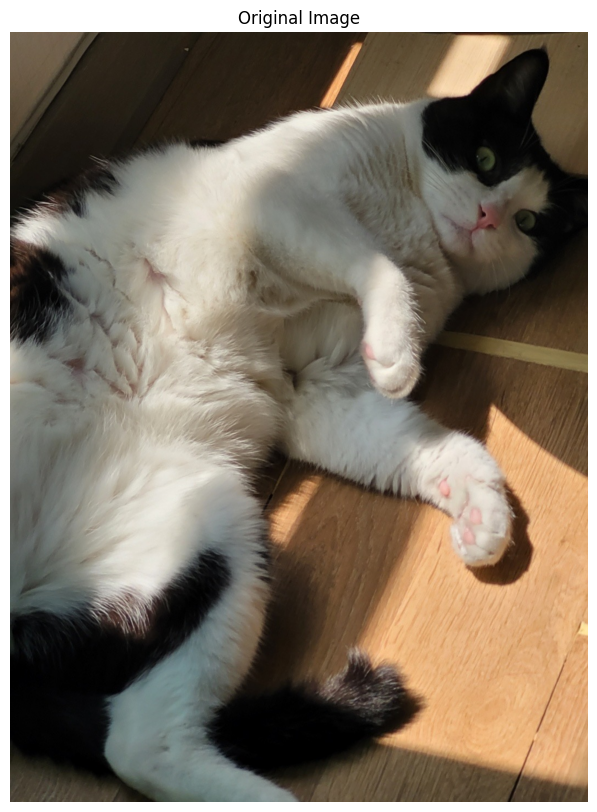

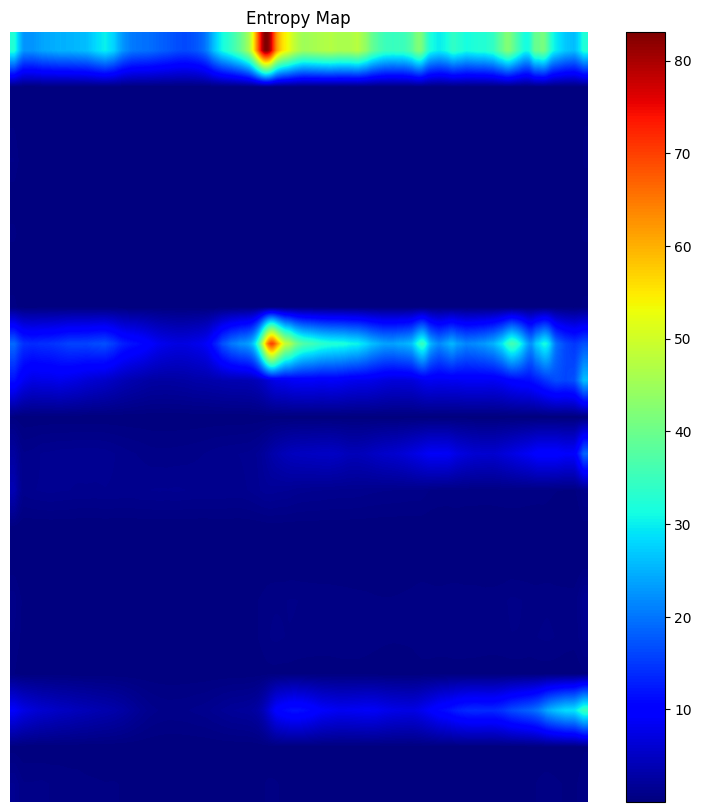

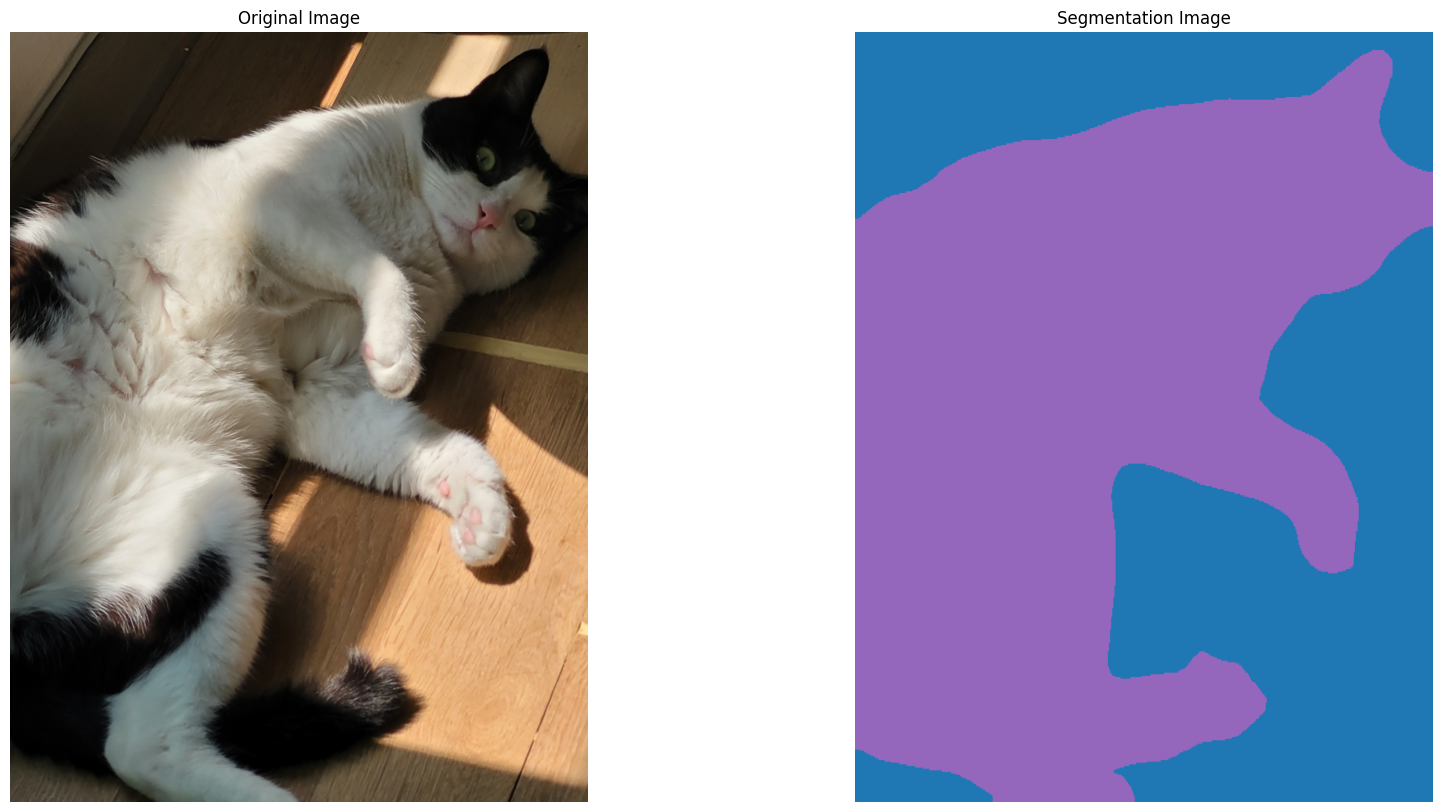

Total Entropy: 5830560.5


In [17]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def calculate_entropy(probabilities, epsilon=1e-6):
    """
    Calculate the entropy map given the class probabilities.
    """
    entropy = -torch.sum(probabilities * torch.log(probabilities + epsilon), dim=1)
    return entropy

def segment_and_entropy(net, path, show_orig=True, show_segmentation=True, dev='cuda'):
    img = Image.open(path).convert('RGB')
    orig_size = img.size

    # 모델의 입력 크기 정의 (DeepLabV3는 일반적으로 512x512 크기를 사용)
    model_input_size = (512, 512)

    if show_orig:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Original Image')
        plt.show()

    # 이미지 전처리 및 모델 입력
    transform = T.Compose([
        T.Resize(model_input_size),  # 모델 입력 크기로 조정
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inp = transform(img).unsqueeze(0).to(dev)
    out = net(inp)['out']

    # 소프트맥스 확률 계산
    out_soft = torch.softmax(out, dim=1)

    # 엔트로피 맵 계산
    entropy_map = calculate_entropy(out_soft.squeeze(0))

    # 모델의 출력 크기 확인
    output_size = entropy_map.size()

    # 원본 이미지와 모델 출력 사이의 비율 계산
    width_ratio = orig_size[0] / output_size[1]
    height_ratio = orig_size[1] / output_size[0]

    # 엔트로피 맵 리사이즈
    transform_resize = T.Resize(size=(orig_size[1], orig_size[0]))
    entropy_map_resized = transform_resize(entropy_map.unsqueeze(0)).squeeze(0)

    # 엔트로피 맵 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(entropy_map_resized.cpu().detach().numpy(), cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('Entropy Map')
    plt.show()

    entropy = torch.sum(entropy_map_resized).item()

    # 시각화 세그멘테이션 결과
    if show_segmentation:
          # 모델의 출력 클래스 인덱스를 가져오기
          output_classes = torch.argmax(out_soft, dim=1).squeeze(0).cpu().numpy()

          # 각 클래스에 대해 색상 맵 정의
          num_classes = out_soft.size(1)
          color_map = plt.get_cmap('tab20', num_classes)

          # 클래스에 색상 맵 적용
          segmented_img = color_map(output_classes / num_classes)  # Normalize to [0, 1] range
          segmented_img = (segmented_img[:, :, :3] * 255).astype(np.uint8)  # Convert to 8-bit RGB

          # 세그멘테이션 결과를 원본 이미지 크기로 리사이즈
          segmented_img_resized = Image.fromarray(segmented_img).resize(orig_size, Image.NEAREST)

          # 원본 이미지와 세그멘테이션 결과 오버레이
          plt.figure(figsize=(20, 10))
          plt.subplot(1, 2, 1)
          plt.imshow(img)
          plt.axis('off')
          plt.title('Original Image')

          plt.subplot(1, 2, 2)
          plt.imshow(segmented_img_resized)
          plt.axis('off')
          plt.title('Segmentation Image')

          plt.show()

    return entropy

# 모델 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dlab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval().to(device)

# 이미지 경로 설정
path = "/content/IMG_0783.jpeg"  # 이미지 경로

# 엔트로피 계산 및 시각화
entropy = segment_and_entropy(dlab, path, show_orig=True, show_segmentation=True, dev=device)
print(f'Total Entropy: {entropy}')
